# The Large Magellanic Cloud: Proper Motion and Rotation

The code in this notebook reproduces a few key figures and results from a paper by [van der Marel & Sahlmann (2016)](http://iopscience.iop.org/article/10.3847/2041-8205/832/2/L23) on "First Gaia Local Group Dynamics: Magellanic Clouds Proper Motion and Rotation", based on the Tycho-Gaia Astrometric Solution (Gaia DR1).

In [1]:
from warnings import warn

from astropy import units
from corner import corner
import emcee
from emcee.utils import sample_ball
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d as interp
from scipy.optimize import minimize

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Constants

In [3]:
# van der Marel & Kallivayalil 2014
alpha0 = np.deg2rad(78.76)
#alpha0_err = np.deg2rad(0.52)
delta0 = np.deg2rad(-69.19)
#delta0_err = np.deg2rad(0.25)

# van der Marel et al. 2002
vlos0 = 262.2 # km/s
#vlos0_err = 3.4 # km/s

# Freedman et al. 2001
# m - M = 18.50 +- 0.10
D0 = 50.1 # kpc
#D0_err = 2.5 # kpc
D_const = float(1*units.kpc/units.km)*float(1*units.mas/units.rad)*float(1*units.s/units.year)

## Data

In [4]:
# Table 1 from van der Marel & Sahlmann 2016
df = pd.read_csv("table1.csv")

In [5]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
HIP_ID,2.239200e+04,2.275800e+04,2.279400e+04,2.284900e+04,2.288500e+04,2.290000e+04,2.298900e+04,2.317700e+04,2.342800e+04,2.352700e+04,...,2.544800e+04,2.561500e+04,2.589200e+04,2.613500e+04,2.622200e+04,2.633800e+04,2.674500e+04,2.714200e+04,2.781900e+04,2.786800e+04
GAIA_ID,4.655350e+18,4.655510e+18,4.655461e+18,4.661770e+18,4.661721e+18,4.655137e+18,4.655158e+18,4.662294e+18,4.654622e+18,4.655037e+18,...,4.658486e+18,4.660176e+18,4.660125e+18,4.660246e+18,4.657281e+18,4.657700e+18,4.657628e+18,4.657723e+18,4.659189e+18,4.659091e+18
alpha,7.230170e+01,7.343040e+01,7.355940e+01,7.373900e+01,7.384000e+01,7.388530e+01,7.419620e+01,7.478780e+01,7.553080e+01,7.587330e+01,...,8.164540e+01,8.208470e+01,8.291010e+01,8.359360e+01,8.381930e+01,8.413490e+01,8.524090e+01,8.631930e+01,8.829180e+01,8.845710e+01
delta,-6.945650e+01,-6.871480e+01,-6.921010e+01,-6.675240e+01,-6.743650e+01,-6.996250e+01,-6.984020e+01,-6.566770e+01,-7.133700e+01,-7.069980e+01,...,-6.886870e+01,-6.740510e+01,-6.746990e+01,-6.702320e+01,-6.967730e+01,-6.890050e+01,-6.925860e+01,-6.899780e+01,-6.811860e+01,-6.831320e+01
muW,-2.012000e+00,-1.772000e+00,-1.895000e+00,-1.756000e+00,-1.766000e+00,-1.951000e+00,-1.869000e+00,-1.613000e+00,-1.973000e+00,-1.942000e+00,...,-1.710000e+00,-1.568000e+00,-1.587000e+00,-1.633000e+00,-1.723000e+00,-1.874000e+00,-1.779000e+00,-1.733000e+00,-1.560000e+00,-1.661000e+00
muW_err,1.510000e-01,1.600000e-01,8.800000e-02,1.200000e-01,1.450000e-01,2.320000e-01,2.340000e-01,1.620000e-01,1.460000e-01,2.400000e-01,...,1.380000e-01,2.040000e-01,1.820000e-01,9.500000e-02,1.870000e-01,1.850000e-01,2.310000e-01,1.420000e-01,1.530000e-01,1.540000e-01
muN,-2.260000e-01,-2.960000e-01,-1.220000e-01,-4.500000e-02,-3.000000e-02,-1.020000e-01,1.500000e-02,2.600000e-02,-9.900000e-02,7.700000e-02,...,5.870000e-01,4.790000e-01,6.690000e-01,4.290000e-01,4.970000e-01,6.210000e-01,5.180000e-01,7.050000e-01,8.340000e-01,8.430000e-01
muN_err,1.510000e-01,1.710000e-01,8.800000e-02,1.300000e-01,1.470000e-01,2.210000e-01,2.270000e-01,1.590000e-01,1.400000e-01,2.300000e-01,...,1.330000e-01,2.080000e-01,1.860000e-01,1.130000e-01,1.880000e-01,2.000000e-01,2.420000e-01,1.370000e-01,1.060000e-01,1.110000e-01


In [6]:
df["alpha"] = np.deg2rad(df["alpha"])
df["delta"] = np.deg2rad(df["delta"])

In [7]:
# angular offsets from dynamical center
df["x"] = -(df["alpha"]-alpha0)*np.cos(df["delta"])
df["y"] = df["delta"]-delta0

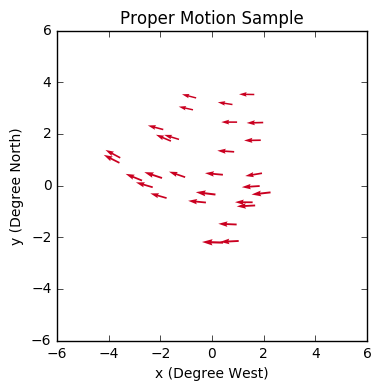

In [8]:
fig, ax = plt.subplots()
ax.set_title("Proper Motion Sample")
ax.quiver(np.rad2deg(df["x"]), np.rad2deg(df["y"]), df["muW"], df["muN"], minshaft=2, color="#ca0020")
ax.set_aspect("equal")
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_xlabel("x (Degree West)")
ax.set_ylabel("y (Degree North)")
plt.show()

## Model Setup

In [9]:
def v_rot(Rp, slope):
    """Rotation Curve
    
    The rotation curve is parameterized to increase linearly with radius.
    It is expected to flatten, but the TGAS data by itself does not constrain
    the turnover point and the parameters V0 and R0 would be degenerate.
    
    if Rp < R0:
        return V0*Rp/R0
    else:
        return V0
        
    van der Marel & Sahlmann 2016, fig. 2
    """
    return slope*Rp

In [10]:
def v_cm(vt, thetat, rho, phi):
    """Center-of-Mass Motion
    
    van der Marel et al. 2002, eq. 13
    """
    v2 = vt*np.cos(rho)*np.cos(phi-thetat)-vlos0*np.sin(rho)
    v3 = -vt*np.sin(phi-thetat)
    return v2, v3

def v_int(slope, theta, inc, rho, phi, s=1):
    """Internal Rotation
    
    van der Marel et al. 2002, eq. 21
    """
    Rp = D0*np.sin(rho)*(np.cos(inc)**2*np.cos(phi-theta)**2+np.sin(phi-theta)**2)**0.5/(np.cos(inc)*np.cos(rho)-np.sin(inc)*np.sin(rho)*np.sin(phi-theta))
    v = s*v_rot(Rp, slope)/(np.cos(inc)**2*np.cos(phi-theta)**2+np.sin(phi-theta)**2)**0.5
    v2 = v*np.sin(inc)*np.cos(phi-theta)*(np.cos(inc)*np.sin(rho)+np.sin(inc)*np.cos(rho)*np.sin(phi-theta))
    v3 = -v*(np.cos(inc)**2*np.cos(phi-theta)**2+np.sin(phi-theta)**2)
    return v2, v3

def predict(vt, thetat, slope, Theta, inc, alpha, delta, component=None):
    """Proper Motion

    van der Marel & Cioni 2001, eq. 1-3
    van der Marel et al. 2002, eq. 9-11
    """
    theta = Theta + np.pi/2
    
    rho = np.arccos(np.cos(delta)*np.cos(delta0)*np.cos(alpha-alpha0)+np.sin(delta)*np.sin(delta0))
    phi = np.arctan2(np.sin(delta)*np.cos(delta0)-np.cos(delta)*np.sin(delta0)*np.cos(alpha-alpha0),
                    -np.cos(delta)*np.sin(alpha-alpha0))
    
    v2_cm, v3_cm = v_cm(vt, thetat, rho, phi)
    v2_int, v3_int = v_int(slope, theta, inc, rho, phi)
        
    if component is None:
        v2 = v2_cm + v2_int
        v3 = v3_cm + v3_int
    elif component == "cm":
        v2 = v2_cm
        v3 = v3_cm
    elif component == "int":
        v2 = v2_int
        v3 = v3_int   
    
    Gamma = np.arctan2((np.cos(delta0)*np.sin(alpha-alpha0))/np.sin(rho),
                       (np.sin(delta)*np.cos(delta0)*np.cos(alpha-alpha0)-np.cos(delta)*np.sin(delta0))/np.sin(rho))
    mu = (np.cos(inc)*np.cos(rho)-np.sin(inc)*np.sin(rho)*np.sin(phi-theta))/(D_const*D0*np.cos(inc))
    muW = mu*(-np.sin(Gamma)*v2-np.cos(Gamma)*v3)
    muN = mu*(np.cos(Gamma)*v2-np.sin(Gamma)*v3)
    return muW, muN

## Model Fitting

In [11]:
def lnlike(p):
    muW, muN = np.transpose([predict(*p, alpha, delta) for alpha, delta in zip(df["alpha"], df["delta"])])
    return -np.sum((muW-df["muW"])**2/df["muW_err"]**2+(muN-df["muN"])**2/df["muN_err"]**2)/2

p0 = [450, np.deg2rad(170), 30, np.deg2rad(120), np.deg2rad(40)]
fit = minimize(lambda *args: -lnlike(*args), p0)
if not fit.success:
    warn(fit.message)
fit = fit.x

In [12]:
print(f"  muW = {fit[0]*np.cos(fit[1])/(D0*D_const):6.4} mas/yr")
print(f"  muN = {fit[0]*np.sin(fit[1])/(D0*D_const):6.3} mas/yr")
print(f"slope = {fit[2]:6.3} km/s")
print(f"Theta = {np.rad2deg(fit[3]):6.4} deg")
print(f"  inc = {np.rad2deg(fit[4]):6.3} deg")

  muW = -1.874 mas/yr
  muN =  0.223 mas/yr
slope =   28.0 km/s
Theta =  123.6 deg
  inc =   44.1 deg


In [13]:
def pmfield(p, N=20, component=None, diff=False):
    
    x, y = np.deg2rad([np.linspace(50, 110, N), np.linspace(-80, -60, N)])
    X, Y = np.meshgrid(x, y)
    
    U = np.zeros((N, N))
    V = np.zeros((N, N))
        
    for i in range(N):
        for j in range(N):
            alpha, delta = X[i, j], Y[i, j]
            muW, muN = predict(*p, alpha, delta, component)
            U[i, j], V[i, j] = muW, muN
   
    U0 = interp(x, y, U, kind="cubic")(alpha0, delta0)
    V0 = interp(x, y, V, kind="cubic")(alpha0, delta0)
        
    if diff:
        U -= U0
        V -= V0

    return (-np.rad2deg((X-alpha0)*np.cos(Y)), np.rad2deg(Y-delta0), U, V), (U0, V0)

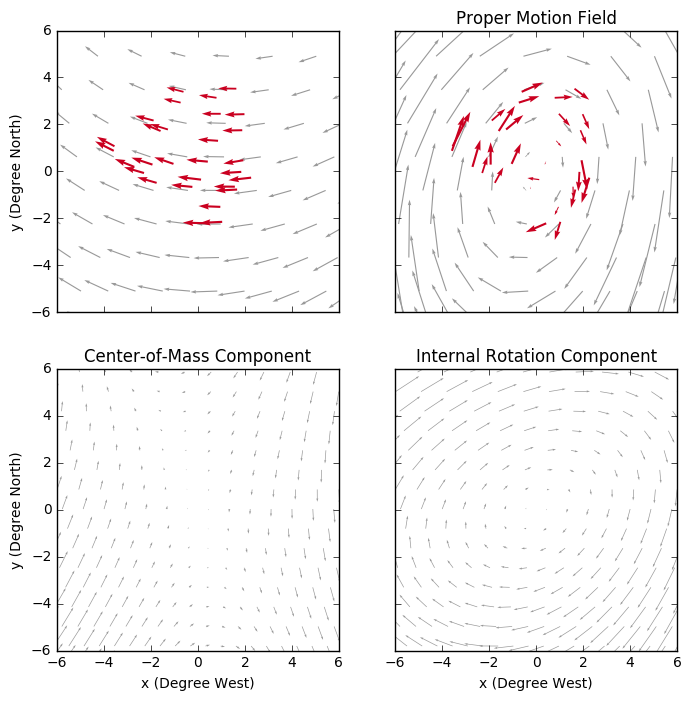

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

ax[0,0].quiver(*pmfield(fit, N=15)[0], scale=25, minshaft=2, color="#999999")
ax[0,0].quiver(np.rad2deg(df["x"]), np.rad2deg(df["y"]), df["muW"], df["muN"], scale=25, minshaft=2, color="#ca0020")
ax[0,0].set_aspect("equal")
ax[0,0].set_xlim([-6, 6])
ax[0,0].set_ylim([-6, 6])
ax[0,0].set_ylabel("y (Degree North)")

# Replicates fig. 1 from van der Marel & Sahlmann 2016
ax[0,1].set_title("Proper Motion Field")
(X, Y, U, V), (U0, V0) = pmfield(fit, N=15)
ax[0,1].quiver(X, Y, U-U0, V-V0, scale=5, minshaft=2, color="#999999")
ax[0,1].quiver(np.rad2deg(df["x"]), np.rad2deg(df["y"]), df["muW"]-U0, df["muN"]-V0, scale=5, minshaft=2, color="#ca0020")

# Replicates fig. 10a from van der Marel et al. 2002
ax[1,0].set_title("Center-of-Mass Component")
ax[1,0].quiver(*pmfield(fit, component="cm", diff=True, N=25)[0], scale=10, color="#999999")
ax[1,0].set_xlabel("x (Degree West)")
ax[1,0].set_ylabel("y (Degree North)")

# Replicates fig. 10b from van der Marel et al. 2002
ax[1,1].set_title("Internal Rotation Component")
ax[1,1].quiver(*pmfield(fit, component="int", diff=True, N=25)[0], scale=10, color="#999999")
ax[1,1].set_xlabel("x (Degree West)")

plt.show()

In [15]:
def lnprior(p):
    vt, thetat, slope, Theta, inc = p
    if not(0 < vt < 1000) or not(0 < thetat < 2*np.pi):
        return -np.inf
    if not(0 < slope < 100):
        return -np.inf
    if not(0 < Theta < 2*np.pi) or not(0 < inc < np.pi):
        return -np.inf
    return 0

def lnprob(p):
    lnprior_val = lnprior(p)
    if not np.isfinite(lnprior_val):
        return -np.inf  
    return lnprior_val+lnlike(p)

In [16]:
ndim, nwalkers = 5, 20
niter = 10000
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

In [17]:
p0_err = [10, np.deg2rad(5), 5, np.deg2rad(30), np.deg2rad(10)]
state = sampler.run_mcmc(sample_ball(p0, p0_err, size=nwalkers), niter)

In [18]:
np.mean(sampler.acceptance_fraction)

0.42479500000000003

In [19]:
samples = sampler.chain.copy()

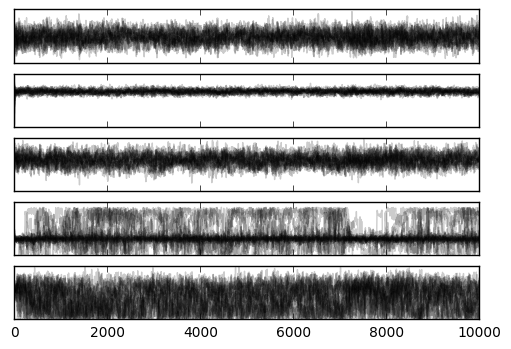

In [20]:
fig, ax = plt.subplots(ndim, sharex=True)
for i in range(ndim):
    ax[i].plot(np.transpose(samples[:,:,i]), color="k", alpha=0.2)
    ax[i].get_yaxis().set_visible(False)

In [21]:
burn = 1000
samples = samples[:,burn:,:].reshape((-1, samples.shape[2]))

In [22]:
fit[[1,3,4]] = np.rad2deg(fit[[1,3,4]])
samples[:,[1,3,4]] = np.rad2deg(samples[:,[1,3,4]])

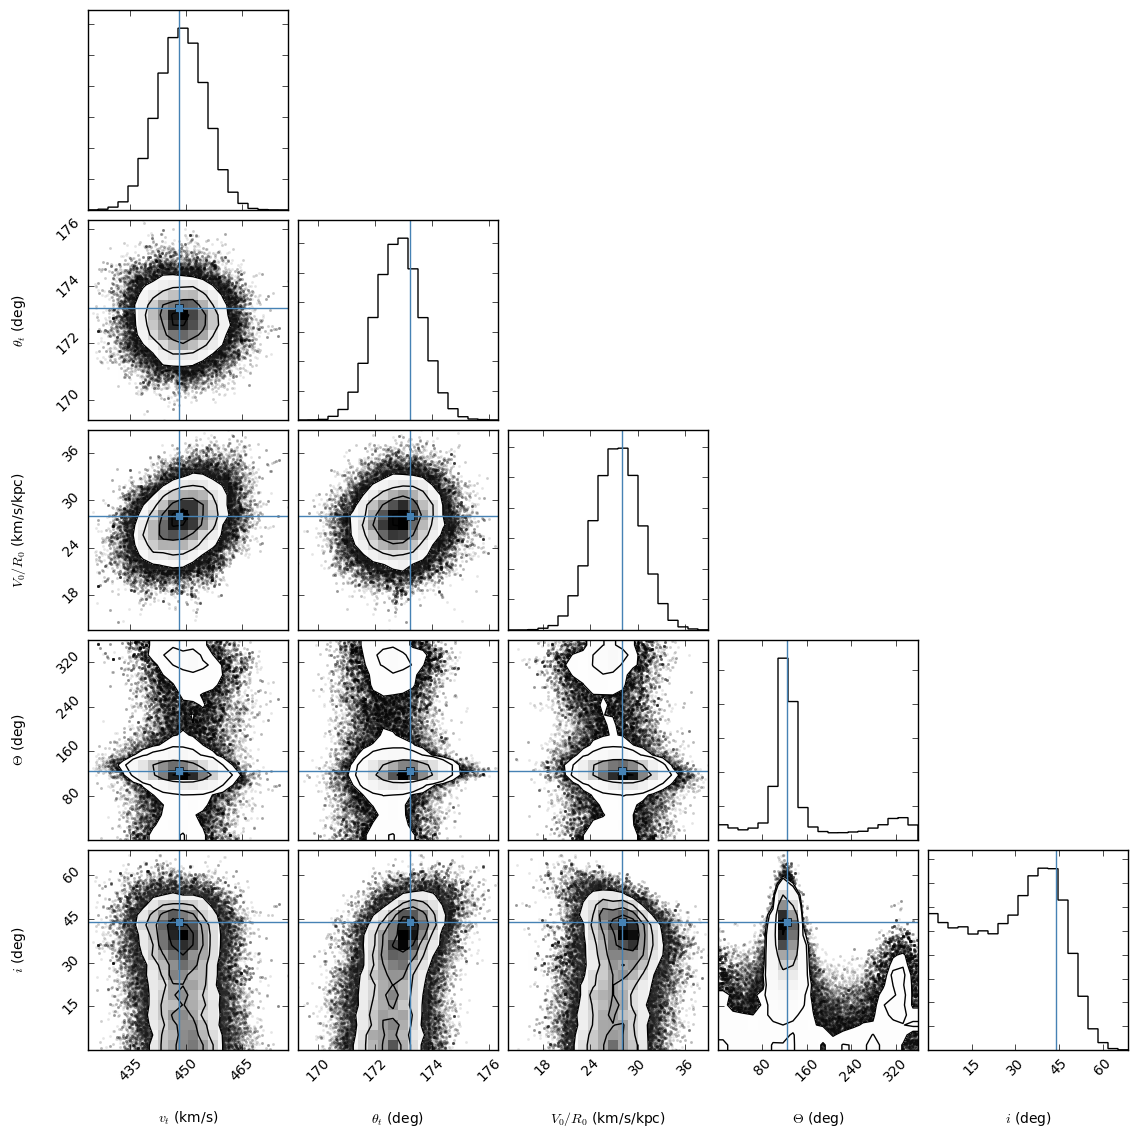

In [23]:
corner(samples,
       truths=fit,
       labels=[r"$v_t$ (km/s)", r"$\theta_t$ (deg)", r"$V_0/R_0$ (km/s/kpc)", r"$\Theta$ (deg)", r"$i$ (deg)"])
plt.show()